In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


from wordcloud import WordCloud, STOPWORDS

import string
from matplotlib import style

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#reading in 2020 tweets for nuclear energy with labels attached
df = pd.read_csv('tweets_2020_labeled.csv',index_col=0)

In [3]:
#Create stopwords list

stopwords_list = stopwords.words('english')
stopwords_list += ['nuclear','energy','…','nuclearenergy','’','核エネルギーの潜在的な危険性は、いくら強調してもし過ぎるということはない。']

In [4]:
X = df['tweet']
y = df['labeled_tweet']

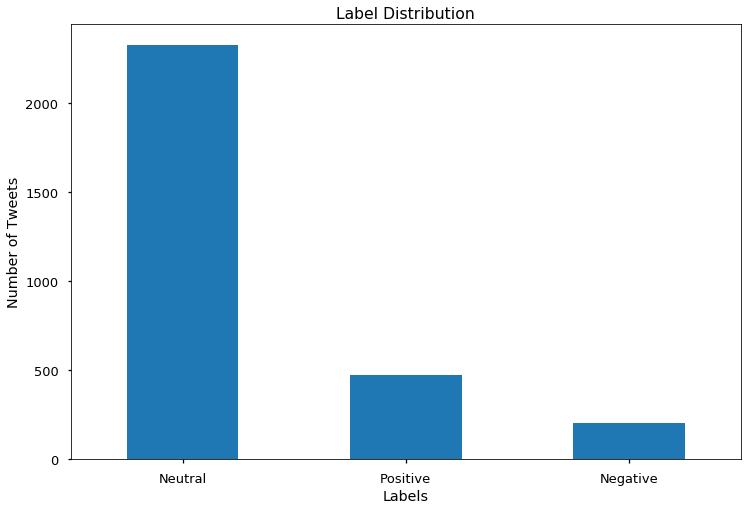

In [5]:
#there are more positive than negative but majority is neutral
plt.style.use('seaborn-talk')
plt.figure() 
fig1 = y.value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Label Distribution')
fig1.set(xticklabels=['Neutral', 'Positive', 'Negative'])
plt.xticks(rotation=0)
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

In [6]:
y.value_counts(normalize=True)

neu    0.775000
pos    0.157667
neg    0.067333
Name: labeled_tweet, dtype: float64

## TF-IDF Vectorizer process for classification

In [7]:
#function to remove punctuation and non-alphabetical characters
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    #text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    #text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    return text

#test = clean_text_round1(tweet_df['tweet'][24])
round1 = lambda x: clean_text_round1(x)
X_fake = pd.DataFrame(X.apply(round1))

In [8]:
X = X_fake['tweet']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

tfidf = TfidfVectorizer(stop_words = stopwords_list)
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)
#tfidf_data_train

In [10]:
tfidf_data_train.shape

(2250, 8037)

### Dummy Classifier

In [11]:
from sklearn.dummy import DummyClassifier

In [12]:
dc_classifier = DummyClassifier(strategy='most_frequent')

dc_classifier.fit(tfidf_data_train, y_train)

dc_train_preds = dc_classifier.predict(tfidf_data_train)
dc_test_preds = dc_classifier.predict(tfidf_data_test)

In [13]:
dc_train_score = accuracy_score(y_train, dc_train_preds)
dc_test_score = accuracy_score(y_test, dc_test_preds)

print('Dummy with TF-IDF')
print("Training Accuracy: {:.4}".format(dc_train_score))
print("Testing Accuracy: {:.4}".format(dc_test_score))

Dummy with TF-IDF
Training Accuracy: 0.7742
Testing Accuracy: 0.7773


### Models - NB & RF

In [15]:
#Naiive Bayes Model

nb_classifier = MultinomialNB()

nb_classifier.fit(tfidf_data_train, y_train)

nb_train_preds = nb_classifier.predict(tfidf_data_train)
nb_test_preds = nb_classifier.predict(tfidf_data_test)

In [16]:
nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)

print('Naiive-Bayes with TF-IDF')
print("Training Accuracy: {:.4}".format(nb_train_score))
print("Testing Accuracy: {:.4}".format(nb_test_score))

Naiive-Bayes with TF-IDF
Training Accuracy: 0.7929
Testing Accuracy: 0.7853


In [19]:
#Random Forest Model

rf_classifier = RandomForestClassifier(n_estimators=500, random_state=0, class_weight='balanced')

rf_classifier.fit(tfidf_data_train, y_train)

rf_test_preds = rf_classifier.predict(tfidf_data_test)
rf_train_preds = rf_classifier.predict(tfidf_data_train)

In [21]:
rf_acc_score_train = accuracy_score(y_train, rf_train_preds)
rf_acc_score = accuracy_score(y_test, rf_test_preds)

print('Random Forest with TF-IDF')
print("Training Accuracy: {:.4}".format(rf_acc_score_train))
print("Testing Accuracy: {:.4}".format(rf_acc_score))

Random Forest with TF-IDF
Training Accuracy: 0.9991
Testing Accuracy: 0.78


In [25]:
#feature importance scores
#Decision tree algorithms like classification offer importance scores based on the reduction in the criterion used to select split points, like Gini or entropy.
feat_importanceDF_rfc_2 = pd.DataFrame(rf_classifier.feature_importances_, index=tfidf.vocabulary_)
feat_importanceDF_rfc_2.sort_values(by=0,ascending=False).head(15)

,0
years,0.016471
avstå,0.014785
angela,0.011872
imp,0.010523
expanding,0.009393
laptop,0.009299
pictwittercomvkzlcwpgzh,0.008645
ahero,0.008049
worrisome,0.007889
wilmington,0.007579


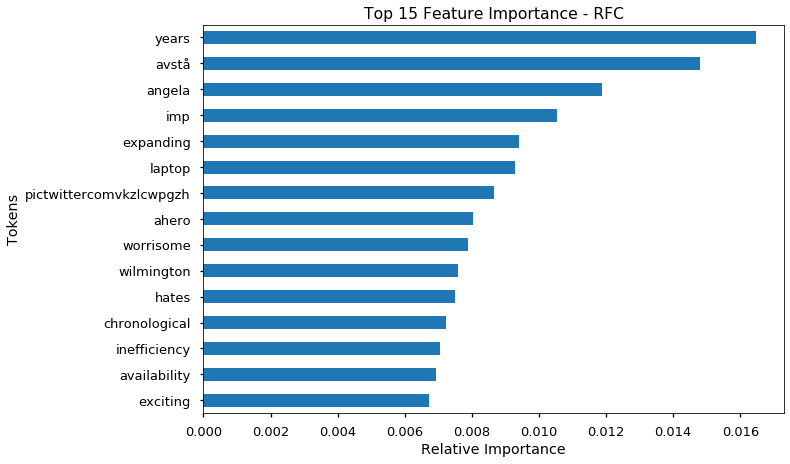

In [24]:
#plot top 5 features for the RFC
feat_importances_2 = pd.Series(rf_classifier.feature_importances_,index=tfidf.vocabulary_)
feat_importances_2.nlargest(15).sort_values().plot(kind='barh')
plt.title("Top 15 Feature Importance - RFC")
plt.xlabel('Relative Importance')
plt.ylabel('Tokens')
plt.show()

In [68]:
#number of features
len(tfidf.vocabulary_)

7702

In [51]:
tfidf.get_feature_names()

['aa',
 'aalto',
 'aarogyasetuapp',
 'ab',
 'abandon',
 'abandoning',
 'abandonment',
 'abc',
 'abeninforma',
 'aberration',
 'ability',
 'able',
 'ableg',
 'aboilsands',
 'abolished',
 'abolition',
 'abolitionism',
 'abortion',
 'abq',
 'abqjournal',
 'abroad',
 'absence',
 'absolute',
 'absolutely',
 'absorbed',
 'absurdist',
 'abt',
 'abudhabi',
 'abundance',
 'abundant',
 'abundantly',
 'abuse',
 'academia',
 'academic',
 'academy',
 'accelerate',
 'accelerated',
 'accelerating',
 'accelerator',
 'accept',
 'acceptable',
 'access',
 'accident',
 'accidental',
 'accommodate',
 'accord',
 'according',
 'account',
 'accumulating',
 'accurate',
 'accurately',
 'accuse',
 'accused',
 'acehoffman',
 'acglobalenergy',
 'acglobalenergys',
 'achievable',
 'achieve',
 'achieved',
 'achievement',
 'achieves',
 'achieving',
 'acid',
 'acknowledge',
 'acolyte',
 'acquire',
 'acquires',
 'acquisition',
 'acronym',
 'across',
 'act',
 'acting',
 'action',
 'activate',
 'active',
 'actively',
 'ac

IndexError: index 15733 is out of bounds for axis 0 with size 7702

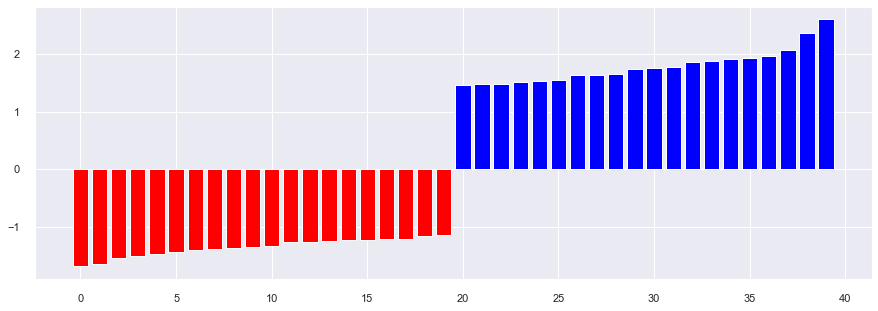

In [65]:
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1,1+2*top_features),feature_names[top_coefficients], rotation=60)
    plt.show()
#cv = CountVectorizer()
#cv.fit(data)
#print len(cv.vocabulary_)
#print cv.get_feature_names()
#X_train = cv.transform(data)

svm = LinearSVC(class_weight='balanced')
svm.fit(tfidf_data_train, y_train)
plot_coefficients(svm, tfidf.get_feature_names())

In [67]:
svm.coef_

array([[ 0.        , -0.04920694, -0.05649543, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05554942, -0.26407844,  0.05445114, ...,  0.02102912,
         0.02102912,  0.02102912],
       [-0.08492157,  0.36224067, -0.05392454, ...,  0.        ,
         0.        ,  0.        ]])

In [66]:
svm_test_preds = svm.predict(tfidf_data_test)
svm_train_preds = svm.predict(tfidf_data_train)

svm_acc_score_train = accuracy_score(y_train, svm_train_preds)
svm_acc_score = accuracy_score(y_test, svm_test_preds)

print('SVM with TF-IDF')
print("Training Accuracy: {:.4}".format(svm_acc_score_train))
print("Testing Accuracy: {:.4}".format(svm_acc_score))

SVM with TF-IDF
Training Accuracy: 0.9924
Testing Accuracy: 0.8213


### Confusion Matrix

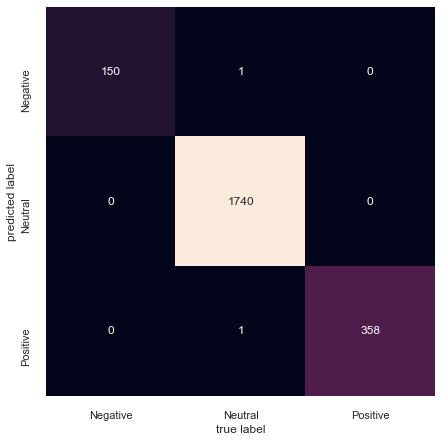

In [26]:
#confusion matrix on train set
sns.set()


mat2 = confusion_matrix(y_train, rf_train_preds)
sns.heatmap(mat2.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

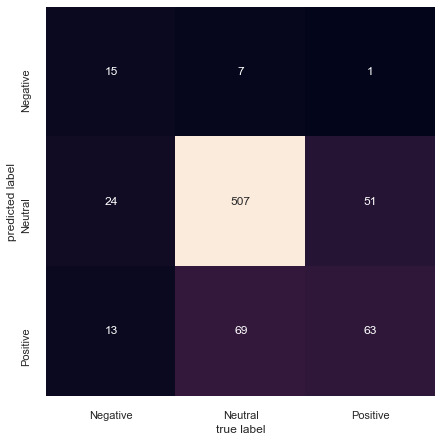

In [27]:
#confusion matrix on test set
sns.set()


mat = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [28]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [29]:
print("Precision Score : ",precision_score(y_test, rf_test_preds, 
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, rf_test_preds, 
                                           average='micro'))

Precision Score :  0.78
Recall Score :  0.78


### Testing Model with Emotions About Nuclear Energy dataset from CROWDFLOWER

In [30]:
df_crowdflower = pd.read_csv('sentiment_nuclear_power.csv', encoding= 'unicode_escape')

In [31]:
df_crowdflower['sentiment'].replace({'Neutral / author is just sharing information': 'neu', 
                                     'Negative': 'neg', 
                                     'Positive': 'pos',
                                     'Tweet NOT related to nuclear energy': 'neu'}, inplace=True)

In [32]:
X_cf = df_crowdflower['tweet_text']
y_cf = df_crowdflower['sentiment']

In [33]:
y_cf.value_counts(normalize=True)

neu    0.847368
neg    0.100000
pos    0.052632
Name: sentiment, dtype: float64

In [35]:
X_cf_fake = pd.DataFrame(X_cf.apply(round1))
X_cf = X_cf_fake['tweet_text']



tfidf_cf = tfidf.transform(X_cf)

In [36]:
tfidf_cf

<190x8037 sparse matrix of type '<class 'numpy.float64'>'
	with 1545 stored elements in Compressed Sparse Row format>

### Running the Model

In [37]:
rf_cf = rf_classifier.predict(tfidf_cf)

rf_cf_score = accuracy_score(y_cf, rf_cf)
print('Random Forest with TF-IDF using crowdflower data')
print("Accuracy: {:.4}".format(rf_cf_score))

Random Forest with TF-IDF using crowdflower data
Accuracy: 0.6684


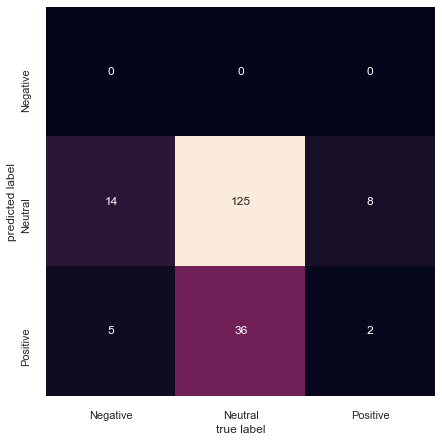

In [38]:
#Confusion Matrix on cf

sns.set()


mat3 = confusion_matrix(y_cf, rf_cf)
sns.heatmap(mat3.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## With Lemmatizer

In [39]:
#reading in 2020 tweets for nuclear energy with labels attached
df_lem = pd.read_csv('tweets_2020_labeled.csv',index_col=0)

In [40]:
#function to remove punctuation and non-alphabetical characters
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    #text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    return text

#test = clean_text_round1(tweet_df['tweet'][24])
round1 = lambda x: clean_text_round1(x)
df_lem.tweet = pd.DataFrame(df_lem.tweet.apply(round1))


In [41]:
def tokenize(text):
    text = [word_tokenize(x) for x in text]
    return text

df_lem.tweet = tokenize(df_lem.tweet)

In [42]:
stopwords_list = stopwords.words('english')
stopwords_list += ['nuclear','energy','…','nuclearenergy','’','核エネルギーの潜在的な危険性は、いくら強調してもし過ぎるということはない。']
df_lem.tweet = df_lem['tweet'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [43]:
p_data =df_lem['tweet']

In [44]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [45]:
# creating a list with all lemmatized outputs
lemmatized_output = []

for listy in p_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [46]:
X_lem = lemmatized_output
# [' '.join(d) for d in processed_data]

y_lem = df_lem['labeled_tweet']
# X[3]

In [47]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer()

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

#tfidf_data_train_lem

In [48]:
#rf

rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0, class_weight = 'balanced')

rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)
rf_train_preds_lem = rf_classifier_lem.predict(tfidf_data_train_lem)

rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_train_score_lem = accuracy_score(y_train_lem, rf_train_preds_lem)
print('Random Forest with Lemmatization Features')
print("Training Accuracy: {:.4}".format(rf_train_score_lem))
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))


Random Forest with Lemmatization Features
Training Accuracy: 0.9975
Testing Accuracy: 0.7733
